In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [3]:
L((path/'train'/'3').ls()), L((path/'train'/'7').ls())

((#6131) [Path('train/3/55705.png'),Path('train/3/32379.png'),Path('train/3/36132.png'),Path('train/3/50201.png'),Path('train/3/39704.png'),Path('train/3/8475.png'),Path('train/3/5139.png'),Path('train/3/32610.png'),Path('train/3/7784.png'),Path('train/3/45704.png')...],
 (#6265) [Path('train/7/23645.png'),Path('train/7/13644.png'),Path('train/7/22228.png'),Path('train/7/2229.png'),Path('train/7/6064.png'),Path('train/7/24505.png'),Path('train/7/26356.png'),Path('train/7/19987.png'),Path('train/7/19592.png'),Path('train/7/49413.png')...])

In [4]:
files = (path/'train'/'3').ls()
im = Image.open(files[0])
im

In [5]:
tens = tensor(im)
tens.shape

torch.Size([28, 28])

In [6]:
def get_dls():
    def get_ds(train_valid):
        def get_X(train_valid, three_seven):
            files = (path/train_valid/three_seven).ls()
            X = torch.stack([tensor(Image.open(x)) for x in files])#.reshape(-1, 28*28)
            return X
        X3, X7 = get_X(train_valid, '3'), get_X(train_valid, '7')
        X = torch.cat([X3, X7])/255.
        y = torch.tensor([1]*len(X3) + [0]*len(X7)).reshape(-1, 1)
        #print(X.shape, y.shape)
        return list(zip(X, y))
    ds1 = DataLoader(get_ds('train'), bs=256, shuffle=True)
    ds2 = DataLoader(get_ds('valid'), bs=256)
    return DataLoaders(ds1, ds2)
                    
dls = get_dls()    

In [8]:
def loss_fn(y, t):
    return torch.where(t==1, 1-y, y).mean()

def batch_accuracy(y, t):
    return ((y>0.5)==t).float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in dls.valid]
    return round(torch.stack(accs).mean().item(), 4)

class BasicOptim:
    def __init__(self,params, lr):
        self.params = list(params)
        self.lr = lr

    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None
            
opt = BasicOptim(model.parameters(), lr=0.1)

In [12]:

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1),
    nn.Sigmoid(),
)

acc = []
for epoch in range(40):
    for X, t in dls.train:
        y = model(X)
        loss = loss_fn(y, t)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    acc.append(validate_epoch(model))

<AxesSubplot:>

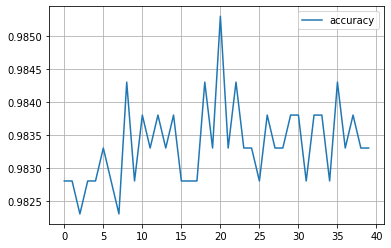

In [13]:
import pandas as pd
pd.DataFrame({'accuracy':acc}).plot(grid=True)

In [ ]:
if False:
    learn = Learner(dls, model, opt_func=SGD, loss_func=loss_fn, metrics=batch_accuracy)
    learn.fit(40, 0.1)
    plt.plot(L(learn.recorder.values).itemgot(2));